In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True' # to prevent kernel from terminating
warnings.filterwarnings('ignore')

In [2]:
data_dir = 'D:\downloads\cell_images\cell_images'

In [3]:
os.listdir(data_dir)

['test', 'train']

In [4]:
test_path = data_dir+'\\test\\'
train_path = data_dir+'\\train\\'

In [5]:
test_path

'D:\\downloads\\cell_images\\cell_images\\test\\'

In [6]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [7]:
os.listdir(train_path+'parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [8]:
# tell image read funct to read the image

In [10]:
para_cell = train_path+'parasitized\\'+'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [11]:
para_cell

'D:\\downloads\\cell_images\\cell_images\\train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

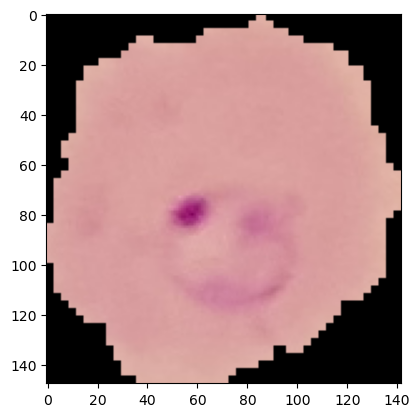

In [14]:
plt.imshow(imread(para_cell))

In [15]:
# Uninfected cell

In [ ]:
os.listdir(train_path+'uninfected')[0]
uninfected_cell = train_path+'uninfected\\'+